In [1]:
import os

current_directory = os.getcwd()
print("Current Directory:", current_directory)


Current Directory: d:\Bittracker2023\experiment\2_analyse_backtest_result


In [2]:
# import sys
# sys.path.insert(0, './experiment/1_backtest')
# sys.path.insert(0, '../1_backtest')
import sys
sys.path.append("../1_backtest")

import matplotlib.pyplot as plt
import pandas 
import numpy
import re
import pickle
import backtest
import heapq

plt.rcParams.update({'font.size': 18})

# Individual Analysis

## Important Functions

In [20]:
def load_pkl_data(path_to_file):
  with open(path_to_file,"rb") as file:
    result = pickle.load(file, encoding='bytes')
    # print('read_goodlist:', result)
    return result

def save_as_pkl_data(result, path_to_file):
  with open(path_to_file,"wb") as file:
    pickle.dump(result, file)

def get_config_list(dataframe: pandas.DataFrame):
  config_list = dataframe[['config_length', 'config_multiplier']]
  return config_list.values.tolist()


class GoodList():
  '''
  Store configurations and its associated profit as heapq
  '''
  def __init__(self, max_length=10):
    self.toplist = []
    self.count = 0
    self.max_length = max_length

  def push(self, value, content):
    '''
    Replace configuration associating with the smallest profit/balance with a better one (if there's any) 
    '''
    if len(self.toplist) < self.max_length:
      heapq.heappush(self.toplist, (value, content))
    elif value > heapq.nsmallest(1, self.toplist)[0][0]:
      heapq.heapreplace(self.toplist, (value, content))


def get_top10_length_riskAdjusted(df):
    # Length
    goodlist_length = GoodList()
    for length in range(7,23):
        balance = list(df[df['config_length'].values == length]['balance'])

        # Calculate risk-adjusted return for
        median_return = numpy.median(balance)
        std = numpy.std(balance)
        sharpe_ratio = median_return/std

        goodlist_length.push(sharpe_ratio, length)

    return goodlist_length

def get_top10_multiplier_riskAdjusted(df):
    # Length
    goodlist_multiplier = GoodList()
    for multiplier in numpy.arange(7,23):
        balance = list(df[df['config_multiplier'].values == multiplier]['balance'])

        # Calculate risk-adjusted return 
        median_return = numpy.median(balance)
        std = numpy.std(balance)
        sharpe_ratio = median_return/std

        goodlist_multiplier.push(sharpe_ratio, multiplier)

    return goodlist_multiplier

def get_top_backtest_result_with_these_configs(backtest_df: pandas.DataFrame, good_length: list, good_multiplier: list, output_path: str):
    '''
    Get top 10 config that has either length or multiplier in top(10) length and top(10) multiplier
    '''
    # if output_path == None: 
    #     output_path = f"backtest_summary/backtest_withBestConfig_{coin_timeframe}.csv"
    
    backtest_df.sort_values(by='balance', ascending=False, inplace=True)
    backtest_df = backtest_df[ backtest_df['config_length'].isin(good_length) & 
                               backtest_df['config_multiplier'].isin(good_multiplier)]
    backtest_df = backtest_df.iloc[:50,:]
    backtest_df.to_csv(output_path)
    return backtest_df
    

def save_good_configs(coin_timeframe, good_lengths, good_multipliers, good_config_pairs, filepath = './good_configs.csv'):
    with open(filepath, "a") as file:
        file.write('{}, \"{}\", \"{}\", \"{}\"\n'.format(coin_timeframe, str(good_lengths)[1:-1], str(good_multipliers)[1:-1], str(good_config_pairs)))



def plot_balance_against_length_multiplier(df, coin_timeframe):
    df['balance_std'] = (df['balance'] - df['balance'].mean()) / df['balance'].std()

    # Plot balances distribution against Length and Multiplier 
    balance_for_lengths = []
    balance_for_multipliers = []
    
    # Length
    for length in range(4,21):
      balance_for_each_length = list(df[df['config_length'].values == length]['balance'])
      balance_for_lengths.append(balance_for_each_length)

    fig = plt.figure(figsize=[22, 6])
    ax = fig.add_subplot(1, 2, 1)
    ax.boxplot(balance_for_lengths);
    ax.set_xticklabels(range(4,21))
    ax.set_title('Balance vs. Length')

    # Multiplier
    for multiplier in numpy.arange(4,20.5,0.5):
      balance_for_each_multiplier = list(df[df['config_multiplier'].values == multiplier]['balance'])
      balance_for_multipliers.append(balance_for_each_multiplier)

    ax = fig.add_subplot(1, 2, 2)
    ax.boxplot(balance_for_multipliers);
    ax.set_xticklabels(numpy.arange(4,20.5,0.5))
    ax.set_title('Balance vs. Multiplier')

def plot_pnl_distribution_for_topConfigs(df, good_length, good_multiplier):
    '''
    Plot PnL histogram for TOP lengths and multipliers
    ''' 
    profit_amounts = []
    loss_amounts = []
    for multiplier in good_multiplier:
      for length in good_length:
        queried_df = df.copy().query(f"config_length=={length} & config_multiplier=={multiplier}")
        profit_amounts = profit_amounts + re.sub("\[|\]|\"|\s", "", queried_df.iloc[0].profit_amounts).split(',')
        loss_amounts = loss_amounts + re.sub("\[|\]|\"|\s", "", queried_df.iloc[0].loss_amounts).split(',')

    profit_amounts = [float(x) for x in profit_amounts]
    loss_amounts = [float(x) for x in loss_amounts]

    fig = plt.figure(figsize=[16, 9])
    ax = fig.add_subplot(2, 1, 1)
    ax.hist(profit_amounts, 101);
    # ax.set_xticks(range(0,600,20))  #
    ax.set_title('Profits distribution of Top Lengths')

    ax = fig.add_subplot(2, 1, 2)
    ax.hist(loss_amounts, 101);
    # ax.set_xticks(range(0,600,20))
    ax.set_title('Losses distribution of Top Multipliers')

def plot_pnl_distribution_for_bestConfig(df, best_length, best_multiplier):
    '''
    Plot PnL histogram just for best length and multiplier
    '''

    print("Average profit and loss per trade of the best_length and best_multiplier")
    queried_df = df.query(f"config_length=={best_length} & config_multiplier=={best_multiplier}").copy()
    print(queried_df[['average_profit','average_loss']])

    # Convert strings to list
    profit_amounts = []
    loss_amounts = []
    
    # Regex operation is to remove punctuation marks and return a 'clean' string of numbers
    profit_amounts = profit_amounts + re.sub("\[|\]|\"|\s", "", queried_df.iloc[0].profit_amounts).split(',') 
    loss_amounts = loss_amounts + re.sub("\[|\]|\"|\s", "", queried_df.iloc[0].loss_amounts).split(',')

    # Convert int to float
    profit_amounts = [float(x) for x in profit_amounts]
    loss_amounts = [float(x) for x in loss_amounts]

    fig = plt.figure(figsize=[16, 9])
    ax = fig.add_subplot(2, 1, 1)
    ax.hist(profit_amounts, 101);
    # ax.set_xticks(range(0,600,20))  #
    ax.set_title('Profits distribution of The Best Length')

    ax = fig.add_subplot(2, 1, 2)
    ax.hist(loss_amounts, 101);
    # ax.set_xticks(range(0,600,20))
    ax.set_title('Losses distribution of The Best Multiplier')


## Analyse backtest result distribution, pick top configs with highest risk-adjusted returns

good_length:
[8, 17, 13, 21, 16, 12, 19, 20, 18, 22] 
good_multiplier:
[18, 17, 19, 10, 9, 8, 22, 7, 21, 20]
best_length: 18 
best_multiplier: 7


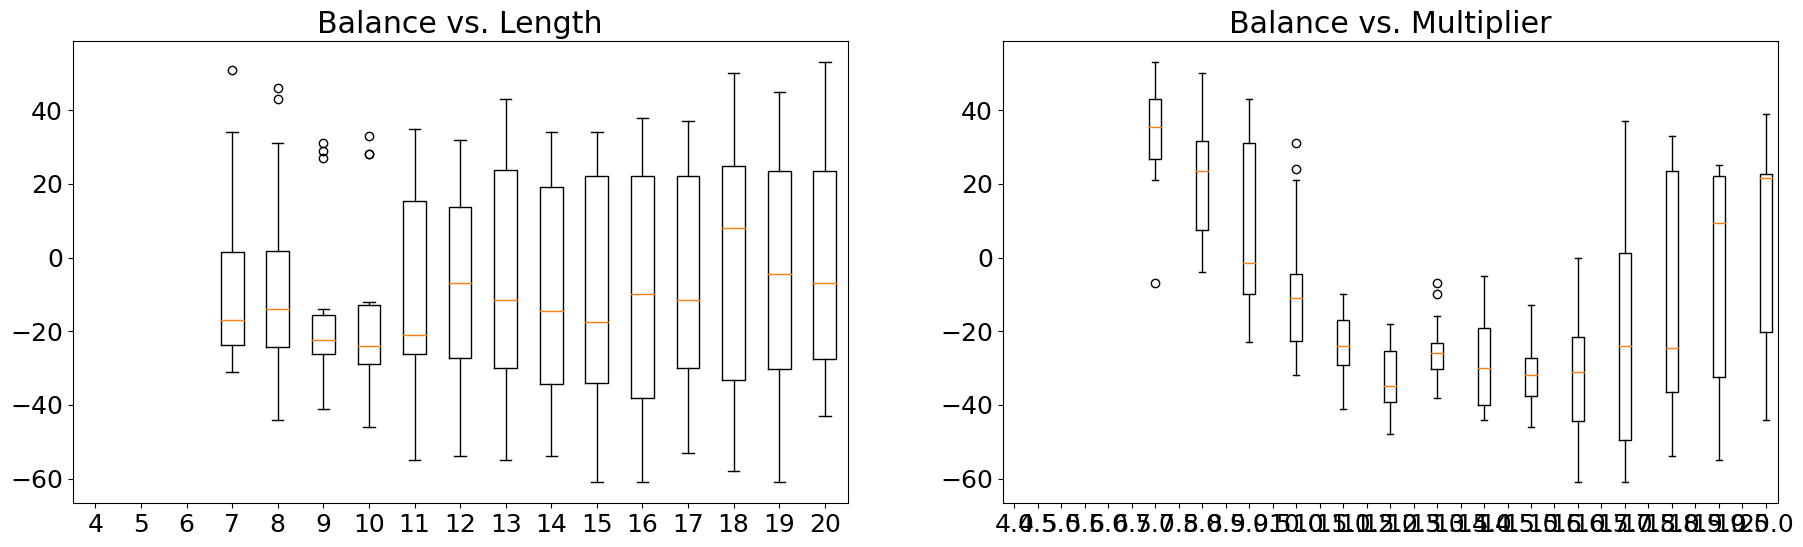

In [28]:
coin = 'btc'
timeframe = '4h'
coin_timeframe = f'{coin}_{timeframe}'
backtest_result_df = pandas.read_csv(f"../1_backtest/backtest_result_{coin_timeframe}.csv")
backtest_result_df.fillna(0, inplace=True)

top10_length = get_top10_length_riskAdjusted(backtest_result_df).toplist
top10_multiplier = get_top10_multiplier_riskAdjusted(backtest_result_df).toplist

good_length_list = [item[1] for item in top10_length]
good_multiplier_list = [item[1] for item in top10_multiplier]

best_length = heapq.nlargest(1, top10_length)[0][1]
best_multiplier = heapq.nlargest(1, top10_multiplier)[0][1]

print(f'good_length:\n{good_length_list} ')
print(f'good_multiplier:\n{good_multiplier_list}')
print(f'best_length: {best_length} ')
print(f'best_multiplier: {best_multiplier}')

plot_balance_against_length_multiplier(backtest_result_df, coin_timeframe)

backtest_result_df = get_top_backtest_result_with_these_configs(backtest_result_df, good_length_list, good_multiplier_list, f"./backtest_result_filtered_with_good_configs_{coin_timeframe}.csv")

# Don't think we need this data which can't share any good info: 
# good_config_pairs = get_config_list(backtest_result_df)
# save_good_configs(coin_timeframe, good_length, good_multiplier, good_config_pairs, f"./good_configs_{coin_timeframe}.csv")

## Backtest again using top configs on data of different period

In [30]:
from backtest import ResultRecorder, backtest

print(f'coin = {coin}, timeframe = {timeframe}')
length_in_day = 1/6
result_recorder = ResultRecorder()

test_data_df = pandas.read_csv(f"../0_historical_data_period1/{coin}_{timeframe}.csv")

# Rename columns and drop some to reduce memory weight
test_data_df['timestamp'] = test_data_df['time_period_start']
test_data_df['open'] = test_data_df['price_open']
test_data_df['high'] = test_data_df['price_high']
test_data_df['low'] = test_data_df['price_low']
test_data_df['close'] = test_data_df['price_close']
test_data_df.drop(['time_period_start', 'time_open', 
        'price_open', 'price_high', 'price_low', 
        'price_close', 'volume_traded', 'trades_count'], axis=1)
test_data_df = test_data_df.iloc[::-1].reset_index()
print('length_of_df =', len(test_data_df), end=' ')

for length in good_length_list:
    for multiplier in good_multiplier_list:
        print(f'length = {length}, multiplier = {multiplier}')

        supertrend_data, balance = backtest(length, multiplier, result_recorder, df=test_data_df)
        
        result_recorder.add_new_row({
            'coinpair': coin,
            'length_in_days': int(length_in_day*len(supertrend_data)), 
            'balance': int(balance), 
            'config_length': length, 
            'config_multiplier': multiplier, 
            'no_of_orders': result_recorder.order_number, 
            'number_of_profit_order': result_recorder.get_profit_order_number(), 
            'number_of_loss_order': result_recorder.get_loss_order_number(), 
            'average_profit': round(result_recorder.get_average_profit(),1), 
            'average_loss': round(result_recorder.get_average_loss(),1),
            'profit_amounts': f"\"{[round(x, 2) for x in result_recorder.get_profit_orders()]}\"",
            'loss_amounts': f"\"{[round(x, 2) for x in result_recorder.get_loss_orders()]}\"",
            'avarage_pnl_per_month': round(balance / (length_in_day*len(supertrend_data)) * 30,1),
        })

        ## Save trade history for each configuration of each coin and timeframe combination
        result_recorder.save_in_csv(f'backtest_result_on_different_period_{coin_timeframe}.csv')
        result_recorder.reset()
    print()

coin = btc, timeframe = 4h
length_of_df = 4480 length = 8, multiplier = 18


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 8, multiplier = 17


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 8, multiplier = 19


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 8, multiplier = 10
length = 8, multiplier = 9
length = 8, multiplier = 8
length = 8, multiplier = 22


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 8, multiplier = 7
length = 8, multiplier = 21


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 8, multiplier = 20


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



length = 17, multiplier = 18


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 17, multiplier = 17
length = 17, multiplier = 19


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 17, multiplier = 10
length = 17, multiplier = 9
length = 17, multiplier = 8
length = 17, multiplier = 22


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 17, multiplier = 7
length = 17, multiplier = 21


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 17, multiplier = 20


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



length = 13, multiplier = 18


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 13, multiplier = 17
length = 13, multiplier = 19


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 13, multiplier = 10
length = 13, multiplier = 9
length = 13, multiplier = 8
length = 13, multiplier = 22


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 13, multiplier = 7
length = 13, multiplier = 21


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 13, multiplier = 20


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



length = 21, multiplier = 18


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 21, multiplier = 17
length = 21, multiplier = 19


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 21, multiplier = 10
length = 21, multiplier = 9
length = 21, multiplier = 8
length = 21, multiplier = 22


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 21, multiplier = 7
length = 21, multiplier = 21


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 21, multiplier = 20


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



length = 16, multiplier = 18


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 16, multiplier = 17
length = 16, multiplier = 19


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 16, multiplier = 10
length = 16, multiplier = 9
length = 16, multiplier = 8
length = 16, multiplier = 22


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 16, multiplier = 7
length = 16, multiplier = 21


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 16, multiplier = 20


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



length = 12, multiplier = 18


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 12, multiplier = 17
length = 12, multiplier = 19


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 12, multiplier = 10
length = 12, multiplier = 9
length = 12, multiplier = 8
length = 12, multiplier = 22


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 12, multiplier = 7
length = 12, multiplier = 21


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 12, multiplier = 20


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



length = 19, multiplier = 18


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 19, multiplier = 17
length = 19, multiplier = 19


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 19, multiplier = 10
length = 19, multiplier = 9
length = 19, multiplier = 8
length = 19, multiplier = 22


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 19, multiplier = 7
length = 19, multiplier = 21


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 19, multiplier = 20


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



length = 20, multiplier = 18


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 20, multiplier = 17
length = 20, multiplier = 19


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 20, multiplier = 10
length = 20, multiplier = 9
length = 20, multiplier = 8
length = 20, multiplier = 22


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 20, multiplier = 7
length = 20, multiplier = 21


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 20, multiplier = 20


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



length = 18, multiplier = 18


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 18, multiplier = 17
length = 18, multiplier = 19


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 18, multiplier = 10
length = 18, multiplier = 9
length = 18, multiplier = 8
length = 18, multiplier = 22


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 18, multiplier = 7
length = 18, multiplier = 21


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 18, multiplier = 20


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



length = 22, multiplier = 18


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 22, multiplier = 17
length = 22, multiplier = 19


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 22, multiplier = 10
length = 22, multiplier = 9
length = 22, multiplier = 8
length = 22, multiplier = 22


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 22, multiplier = 7
length = 22, multiplier = 21


c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


length = 22, multiplier = 20



c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\duy8a\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Repeat the process for other coins

In [37]:
# coins = ['eth', 'xrp', 'sol']
coins = ['eth', 'btc']
timeframes = ['4h']

for coin in coins:
    for timeframe in timeframes:
        coin_timeframe = f'{coin}_{timeframe}'
        backtest_result_df = pandas.read_csv(f"../1_backtest/backtest_result_{coin_timeframe}.csv")
        backtest_result_df.fillna(0, inplace=True)

        top10_length = get_top10_length_riskAdjusted(backtest_result_df).toplist
        top10_multiplier = get_top10_multiplier_riskAdjusted(backtest_result_df).toplist

        good_length_list = [item[1] for item in top10_length]
        good_multiplier_list = [item[1] for item in top10_multiplier]

        best_length = heapq.nlargest(1, top10_length)[0][1]
        best_multiplier = heapq.nlargest(1, top10_multiplier)[0][1]

        backtest_result_df = get_top_backtest_result_with_these_configs(backtest_result_df, good_length_list, good_multiplier_list, f"./backtest_result_filtered_with_good_configs_{coin_timeframe}.csv")


        # Backtest again using top configs on data of different period
        length_in_day = 1/6
        result_recorder = ResultRecorder()

        test_data_df = pandas.read_csv(f"../0_historical_data_period3/{coin}_{timeframe}.csv")

        # Rename columns and drop some to reduce memory weight
        test_data_df['timestamp'] = test_data_df['time_period_start']
        test_data_df['open'] = test_data_df['price_open']
        test_data_df['high'] = test_data_df['price_high']
        test_data_df['low'] = test_data_df['price_low']
        test_data_df['close'] = test_data_df['price_close']
        test_data_df.drop(['time_period_start', 'time_open', 
                'price_open', 'price_high', 'price_low', 
                'price_close', 'volume_traded', 'trades_count'], axis=1)
        test_data_df = test_data_df.iloc[::-1].reset_index()
        print('length_of_df =', len(test_data_df), end=' ')

        for length in good_length_list:
            print(f'coin_timeframe: {coin_timeframe}')
            for multiplier in good_multiplier_list:
                print(f'length = {length}, multiplier = {multiplier}')

                supertrend_data, balance = backtest(length, multiplier, result_recorder, df=test_data_df)
                
                result_recorder.add_new_row({
                    'coinpair': coin,
                    'length_in_days': int(length_in_day*len(supertrend_data)), 
                    'balance': int(balance), 
                    'config_length': length, 
                    'config_multiplier': multiplier, 
                    'no_of_orders': result_recorder.order_number, 
                    'number_of_profit_order': result_recorder.get_profit_order_number(), 
                    'number_of_loss_order': result_recorder.get_loss_order_number(), 
                    'average_profit': round(result_recorder.get_average_profit(),1), 
                    'average_loss': round(result_recorder.get_average_loss(),1),
                    'profit_amounts': f"\"{[round(x, 2) for x in result_recorder.get_profit_orders()]}\"",
                    'loss_amounts': f"\"{[round(x, 2) for x in result_recorder.get_loss_orders()]}\"",
                    'avarage_pnl_per_month': round(balance / (length_in_day*len(supertrend_data)) * 30,1),
                })

                ## Save trade history for each configuration of each coin and timeframe combination
                supertrend_data.to_csv(f'supertrend_data/period3_{coin_timeframe}_{length}_{multiplier}.csv', index=False)
                # result_recorder.save_in_csv(f'backtest_result_on_period3_{coin_timeframe}.csv')
                # result_recorder.reset()
            print()

length_of_df = 2227 coin_timeframe: btc_4h
length = 8, multiplier = 18
length = 8, multiplier = 17
length = 8, multiplier = 19
length = 8, multiplier = 10
length = 8, multiplier = 9
length = 8, multiplier = 8
length = 8, multiplier = 22
length = 8, multiplier = 7
length = 8, multiplier = 21
length = 8, multiplier = 20

coin_timeframe: btc_4h
length = 17, multiplier = 18
length = 17, multiplier = 17
length = 17, multiplier = 19
length = 17, multiplier = 10
length = 17, multiplier = 9
length = 17, multiplier = 8
length = 17, multiplier = 22
length = 17, multiplier = 7
length = 17, multiplier = 21
length = 17, multiplier = 20

coin_timeframe: btc_4h
length = 13, multiplier = 18
length = 13, multiplier = 17
length = 13, multiplier = 19
length = 13, multiplier = 10
length = 13, multiplier = 9
length = 13, multiplier = 8
length = 13, multiplier = 22
length = 13, multiplier = 7
length = 13, multiplier = 21
length = 13, multiplier = 20

coin_timeframe: btc_4h
length = 21, multiplier = 18
lengt

## Backtest result and analysis

Basics:
- Algo: Supertrend: good with trends in crypto market
- Dataset: Bear dataset: 3.2022-12.2023, Bull data: 3.2020-3.2022


Final thoughts/comments:
1. We should also aim for making more trades = low configs. the more orders it trades, the more chances it has to average out the big losses (if there's any). Of course, profit will be reduced.
2. Many configs have very similar performance, we can consider divide the trade size to many configs in the same trading pair, reducing the impact of low performers.  
3. During the bull market, the algo likes to use greater configs to ride all the way of the bull market. If notice a transition to bull market, we can combine with idea in `3.`, using 50% for more conservative, low configs and the rest for profit-maximising, high configs.  
4. This algo is not very effective and SAFE for small-cap coins as there are not many patterns we can see from the backtest result. They also have greater volatility, make too few trades and their average loss per trade is much higher compared to BTC and ETH (can be x2 or x3 higher). So, using this algo on small-cap coins is not recommended. There is one exception which is XRP in bull market.
5. **Only trade with money you can lose**!!!!!!!!!!!!!!!

Bitcoin
- Best length: 
    - Bear: 19->21, multiplier: 7 and also 21,22 => Conservative bot (19,7) (21,7) (21,21)
        - I'd rather choose multiplier=7 because this allows the bot makes more trades.  (check `Final thoughs 1`)
        - 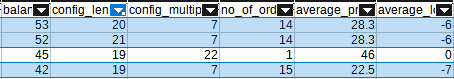
    - Bull: Length 19->21, multiplier: 7,8
        - Varied returns with length 19->21, good multipliers shift to lower values - 7 and 8. (can also use `Final thoughts 2 and 3`)
        - 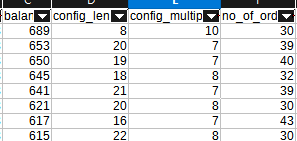

ETH
- Best: 
    - Bear: length 8,9,12->15, multiplier: 7,8. 
        - 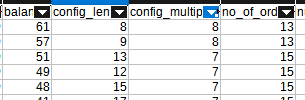
    - Bull: length 8,9,12->20, multiplier 19->22. 
        - Greater configs as the algo tries to ride all the way on bull market (and most configs only make 1 trade ). (check `Final thoughts 2 and 3`)  
        - 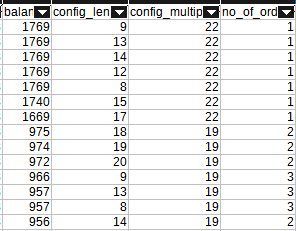

SOL
- Best: 
    - Bear: length 7, 13-17,19, multiplier: 7,8. 
        - Many loss trades (10-15%) during bear market, which can be devastating if they happen consecutively. 
        - Returns (most are ~20%) are even lower than BTC/ETH (40-50%) due to high volatility for small-cap coins.
        - 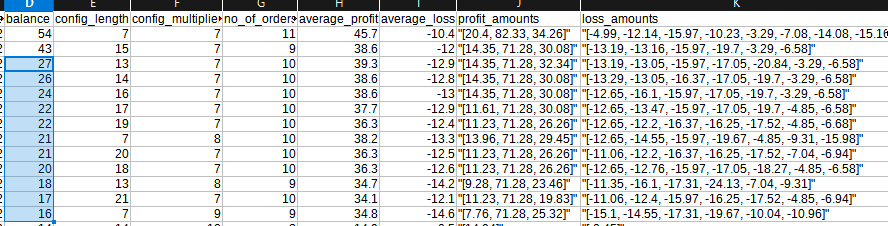
    - Bull: length 17,21, multiplier 7->9, 15,16,19->20,22. 
        - The same phenomenon happens during ETH bull market -- top profits are from high configs
        - 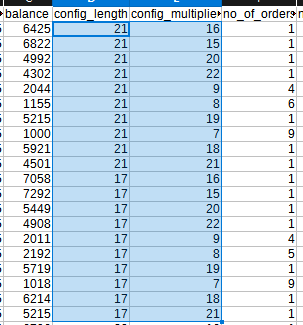

XRP
- Best: 
    - Bear: length 13-15, multiplier: 19->21. 
        - Quite stable returns for top configs but they only make 1 trade :D??
        - 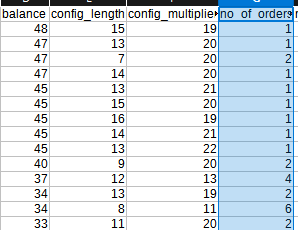
    - Bull: length 7->9,12->15, multiplier 8,11,12,13. 
        - Trading XRP in bull market is actually pretty good. 
        - The bot makes many trades in top configs. And the top configs are in group as well (i.e. many consecutive values)
        - 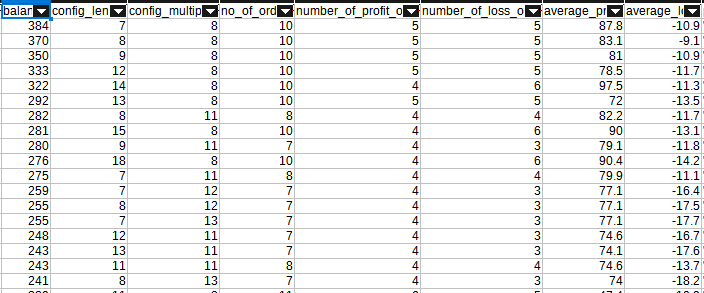



Test on pure bear market, 1.11.2021 - 15.12.2022
Integrate chart, to know where it loses and wins, real psychology when bot is running.

# What now?

Look at the good lengths, multipliers, pairs in [/sandbox/backtest_summary/](/sandbox/backtest_summary/) and choose 1 or more configurations to run BitTracker with